In [5]:
# This is the program which samples IC_{red} values over mixed 2-2-2 quantum correlations.
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
import random

# --- CORE MATH UTILITIES ---

def binary_entropy(p):
    if p <= 1e-12 or p >= 1 - 1e-12:
        return 0
    return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

def get_capacity(pc):
    """Calculates channel capacity k = 1 - h(pc)."""
    return 1 - binary_entropy(pc)

def kl_divergence(p, q, eps=1e-12):
    p = np.clip(p, eps, 1.0)
    q = np.clip(q, eps, 1.0)
    return np.sum(p * np.log2(p / q))

def get_projected_info(p_ab_target, p_ab_source):
    """Calculates redundant information via the convex hull of source distributions."""
    p_a = np.sum(p_ab_target, axis=1)
    p_b_source = np.sum(p_ab_source, axis=0)
    p_b_target = np.sum(p_ab_target, axis=0)
    p_a_given_b_src = p_ab_source / (p_b_source + 1e-15)
    p_a_given_b_tgt = p_ab_target / (p_b_target + 1e-15)
    
    projected_sum = 0
    for b_tgt in range(2):
        objective = lambda l: kl_divergence(
            p_a_given_b_tgt[:, b_tgt], 
            l * p_a_given_b_src[:, 0] + (1 - l) * p_a_given_b_src[:, 1]
        )
        # Yu & Scarani [18] suggest sampling or optimization for this step
        res = minimize_scalar(objective, bounds=(0, 1), method='bounded')
        q_star = res.x * p_a_given_b_src[:, 0] + (1 - res.x) * p_a_given_b_src[:, 1]
        for a in range(4):
            if p_ab_target[a, b_tgt] > 1e-12:
                projected_sum += p_ab_target[a, b_tgt] * np.log2(q_star[a] / p_a[a])
    return projected_sum

# --- BARIZIEN & BANCAL EXTREMAL POINT GENERATION ---

def get_steered_angle(a_x, theta, s):
    """Equation (10) from the Nature Physics paper."""
    # tan^s(theta)
    multiplier = np.tan(theta) if s == 1 else (1.0 / np.tan(theta))
    # Handling arctan/tan carefully for full circle coverage
    return 2 * np.arctan(np.tan(a_x / 2.0) * multiplier)

def is_alternating(theta, a0, a1, b0, b1):
    """
    Theorem 1: Fully alternating condition. 
    Checks 0 <= [a_0^s] <= b0 <= [a_1^t] <= b1 < pi
    """
    # Map to [0, pi] as used in the paper's minimal scenario
    s_a0 = [get_steered_angle(a0, theta, s) % np.pi for s in [1, -1]]
    s_a1 = [get_steered_angle(a1, theta, s) % np.pi for s in [1, -1]]
    
    for a0_tilde in s_a0:
        for a1_tilde in s_a1:
            if not (0 <= a0_tilde <= b0 <= a1_tilde <= b1 < np.pi):
                return False
    return True

def get_extremal_correlation(theta, a0, a1, b0, b1):
    """Generates P(ab|xy) for the extremal point."""
    # |phi_theta> = cos(theta)|00> + sin(theta)|11>
    psi = np.array([np.cos(theta), 0, 0, np.sin(theta)])
    rho = np.outer(psi, psi)
    sz, sx = np.array([[1, 0], [0, -1]]), np.array([[0, 1], [1, 0]])
    
    def get_proj(angle):
        op = np.cos(angle) * sz + np.sin(angle) * sx
        return [0.5 * (np.eye(2) + op), 0.5 * (np.eye(2) - op)]

    alice_meas = [get_proj(a0), get_proj(a1)]
    bob_meas = [get_proj(b0), get_proj(b1)]
    
    p_ab_xy = np.zeros((2, 2, 2, 2))
    for x in range(2):
        for y in range(2):
            for a in range(2):
                for b in range(2):
                    p_ab_xy[a, b, x, y] = np.real(np.trace(rho @ np.kron(alice_meas[x][a], bob_meas[y][b])))
    return p_ab_xy

# --- INFORMATION CAUSALITY PROTOCOL ---

def check_ic_red_noisy(p_ab_xy, pc):
    """Calculates IC_red for a given quantum correlation."""
    p_a_bi = np.zeros((2, 4, 2)) 
    for a_idx in range(4):
        a1, a2 = (a_idx >> 1) & 1, a_idx & 1
        x = a1 ^ a2
        for i in range(2):
            y = i 
            for fract_a in range(2):
                for fract_b in range(2):
                    prob_box = 0.25 * p_ab_xy[fract_a, fract_b, x, y]
                    m = (fract_a ^ a1)
                    # Channel noise applied to Alice's message m
                    p_a_bi[i, a_idx, fract_b ^ m] += prob_box * pc
                    p_a_bi[i, a_idx, fract_b ^ (m ^ 1)] += prob_box * (1-pc)

    mis = []
    for i in range(2):
        p_joint = p_a_bi[i]
        p_a = np.sum(p_joint, axis=1)
        p_b = np.sum(p_joint, axis=0)
        mi = 0
        for a in range(4):
            for b in range(2):
                if p_joint[a, b] > 1e-12:
                    mi += p_joint[a, b] * np.log2(p_joint[a, b] / (p_a[a] * p_b[b]))
        mis.append(mi)
    
    ir = min(get_projected_info(p_a_bi[0], p_a_bi[1]), get_projected_info(p_a_bi[1], p_a_bi[0]))
    return mis[0] + mis[1] - ir

# --- MAIN EXECUTION ---

def run_uniform_volume_simulation(n_steps=6, n_mixtures=5000, n_to_mix=5, pc=0.4999):
    """
    n_steps: Grid resolution for boundary search.
    n_mixtures: Total number of correlations to sample.
    n_to_mix: Maximum number of vertices to combine for each sample.
    """
    k = get_capacity(pc)
    vertices = []
    
    print("Step 1: Building Extremal Boundary Library...")
    theta_range = np.linspace(0.1, np.pi/4, n_steps)
    angle_range = np.linspace(0, np.pi, n_steps)
    for theta in theta_range:
        for a0 in angle_range:
            for b0 in angle_range:
                for a1 in angle_range:
                    for b1 in angle_range:
                        if is_alternating(theta, a0, a1, b0, b1):
                            vertices.append(get_extremal_correlation(theta, a0, a1, b0, b1))
    
    vertices.append(np.full((2, 2, 2, 2), 0.25)) # Add uniform noise center
    num_v = len(vertices)
    print(f"Library complete. {num_v} extremal vertices found.")

    

    ic_values = []

    # #Extremal
    # for i in vertices:
    #   ic_values.append(check_ic_red_noisy(i, pc))
    return k,vertices
    


if __name__ == "__main__":
    # You can now easily adjust both the total samples and the mixture complexity
    vertices=[]
    k,vertices=run_uniform_volume_simulation(n_steps=40, n_mixtures=20000, n_to_mix=5, pc=0.5001)

Step 1: Building Extremal Boundary Library...
Library complete. 1114535 extremal vertices found.


Step 2: Generating 300000 uniform mixtures (using n_to_mix=20)...


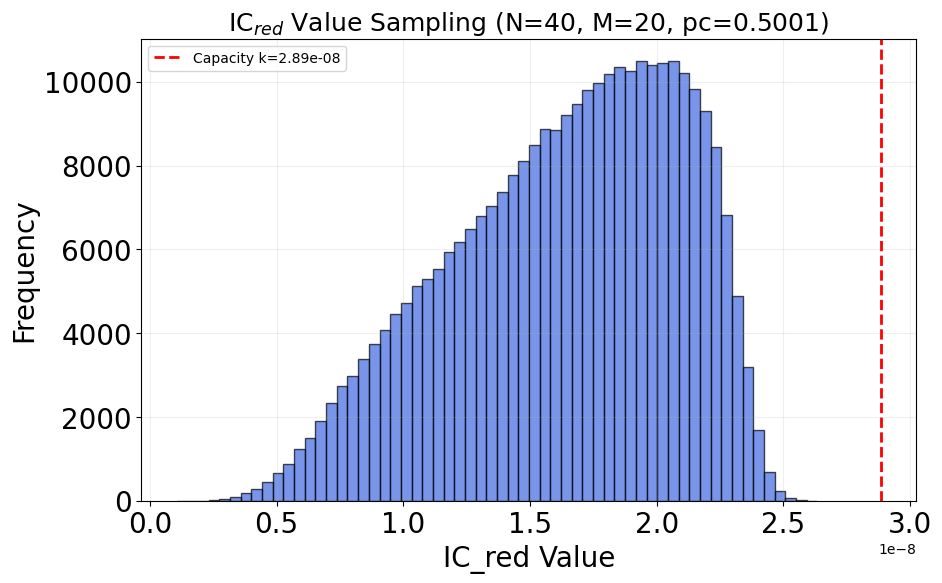

In [47]:
def check_ic_red_noisy(p_ab_xy, pc):
    """Calculates IC_red for a given quantum correlation."""
    p_a_bi = np.zeros((2, 4, 2)) 
    for a_idx in range(4):
        a1, a2 = (a_idx >> 1) & 1, a_idx & 1
        x = a1 ^ a2
        for i in range(2):
            y = i 
            for fract_a in range(2):
                for fract_b in range(2):
                    prob_box = 0.25 * p_ab_xy[fract_a, fract_b, x, y]
                    m = (fract_a ^ a1)
                    # Channel noise applied to Alice's message m
                    p_a_bi[i, a_idx, fract_b ^ m] += prob_box * pc
                    p_a_bi[i, a_idx, fract_b ^ (m ^ 1)] += prob_box * (1-pc)

    mis = []
    for i in range(2):
        p_joint = p_a_bi[i]
        p_a = np.sum(p_joint, axis=1)
        p_b = np.sum(p_joint, axis=0)
        mi = 0
        for a in range(4):
            for b in range(2):
                if p_joint[a, b] > 1e-12:
                    mi += p_joint[a, b] * np.log2(p_joint[a, b] / (p_a[a] * p_b[b]))
        mis.append(mi)
    
    ir = min(get_projected_info(p_a_bi[0], p_a_bi[1]), get_projected_info(p_a_bi[1], p_a_bi[0]))
    return mis[0] + mis[1] - ir


def run_uniform_volume_simulation2(n_steps=6, n_mixtures=5000, n_to_mix=5, pc=0.4999):
    print(f"Step 2: Generating {n_mixtures} uniform mixtures (using n_to_mix={n_to_mix})...")

    ic_values = []

    for _ in range(n_mixtures):
        # Pick a random subset of vertices to form a sub-simplex
        # We use a random number of vertices between 2 and the specified n_to_mix
        # n_to_mix=random.randint(1, 30)
        m = n_to_mix
        chosen = random.sample(vertices, m)
        
        # Dirichlet weights with alpha=1.0 generates a uniform distribution over the sub-simplex
        weights = np.random.dirichlet([1.0] * m)
   
        p_mixed = np.zeros((2, 2, 2, 2))
        for i in range(m):
            p_mixed += weights[i] * chosen[i]
            
        ic_values.append(check_ic_red_noisy(p_mixed, pc))

    # Result Plotting
    plt.figure(figsize=(10, 6))
    plt.hist(ic_values, bins=60, color='royalblue', edgecolor='black', alpha=0.7)
    plt.axvline(x=k, color='red', linestyle='--', linewidth=2, label=f'Capacity k={k:.2e}')
    plt.title(fr'IC$_{{red}}$ Value Sampling (N={n_steps}, M={n_to_mix}, p$_{{c}}={pc})',fontsize=18)
    plt.xlabel('IC_red Value',fontsize=20)
    plt.ylabel('Frequency',fontsize=20)
    plt.xticks(fontsize=20)  # For x-axis numbers
    plt.yticks(fontsize=20)  # For y-axis numbers
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.savefig('ExtremalMixedTest20.pdf')
    plt.show()

run_uniform_volume_simulation2(n_steps=40, n_mixtures=300000, n_to_mix=20, pc=0.5001)